# CNN

### Image classification with Convolutional Neural Networks

**Dogs vs Cats**

A model to categorize images of dogs and cats.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import the required libraries

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogscats/"
sz = 224

- **PATH** is the path to your data
- **sz** is the size that the images will be resized to in order to ensure that the training runs quickly

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['valid', 'test1', 'tmp', 'sample', 'train', 'models']

In [8]:
files = os.listdir(f'{PATH}/valid/cats')[:5]
files

['cat.4597.jpg',
 'cat.1711.jpg',
 'cat.11458.jpg',
 'cat.600.jpg',
 'cat.9411.jpg']

- This folder structure is the most common approach for how image classification dataset is shared and provided.

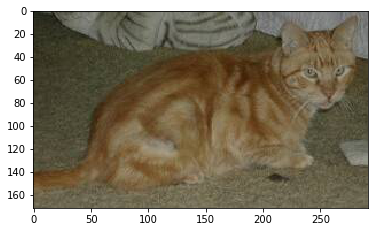

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[3]}')
plt.imshow(img);

### Here is how raw data looks like

In [10]:
img.shape

(172, 292, 3)

In [11]:
img[:4, :4]

array([[[66, 72, 62],
        [71, 77, 67],
        [75, 81, 71],
        [76, 82, 72]],

       [[31, 37, 27],
        [35, 41, 31],
        [40, 46, 36],
        [42, 48, 38]],

       [[31, 37, 25],
        [34, 40, 28],
        [38, 44, 32],
        [38, 44, 32]],

       [[38, 41, 30],
        [40, 43, 32],
        [40, 43, 32],
        [38, 41, 30]]], dtype=uint8)

**Info of raw data**
- img is a 3 dimensional array (a.k.a. rank 3 tensor)
- The three items (e.g. [66, 72, 62]) represents Red Green Blue pixel values between 0 and 255
- The three items (e.g. [158, 110, 62]) represents Red Green Blue pixel values between 0 and 255

## Let’s train a model

We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision

In [12]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047734   0.024252   0.991     
    1      0.033952   0.027152   0.99                         



[array([0.02715]), 0.99]

**Above architevture Info**
- This will do 2 epochs which means it is going to look at the entire set of images twice.
- The last of three numbers in the output is the accuracy on the validation set.
- The first two are the value of loss function (in this case the cross-entropy loss) for the training set and the validation set.
- The start (e.g. 0., 1.) is the epoch number.

### Analyzing results: looking at pictures


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

This is what the validation dataset label (think of it as the correct answers) looks like:

In [13]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

What do these 0’s and 1’s represents?

In [14]:
data.classes

['cats', 'dogs']

- `data` contains the validation and training data
- `learn` contains the model

Let’s make predictions for the validation set (predictions are in log scale):

In [15]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [16]:
log_preds[:10]

array([[ -0.00003, -10.54663],
       [ -0.00006,  -9.69636],
       [ -0.00004, -10.21288],
       [ -0.00383,  -5.5659 ],
       [ -0.00002, -10.76815],
       [ -0.00034,  -7.98731],
       [ -0.     , -12.46821],
       [ -0.00412,  -5.49429],
       [ -0.00012,  -9.00157],
       [ -0.00018,  -8.62575]], dtype=float32)

- The output represents a prediction for cats, and prediction for dogs


In [17]:
preds = np.argmax(log_preds, axis=1) # from log probabilities to 0 or 1
probs = np.exp(log_preds[:, 1])      # PR(dog)

#### Helper function for visualizing the results

In [18]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [19]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims) // rows, i+1)
        sp.axis('Off')
        if titles is not None:
              sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [20]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

In [21]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if(y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly Classified


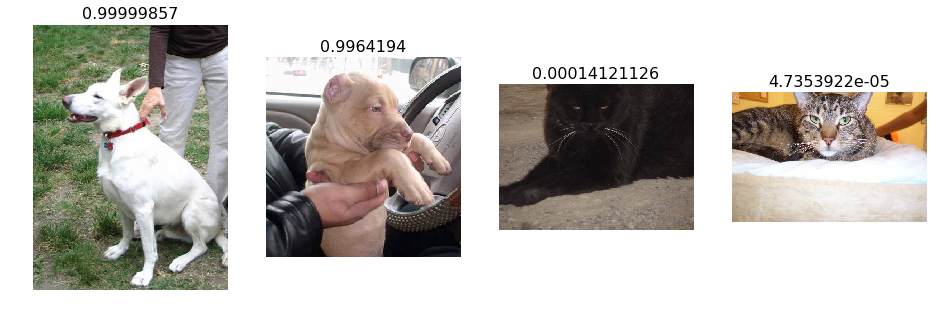

In [22]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(True), "Correctly Classified")

Incorrectly Classified


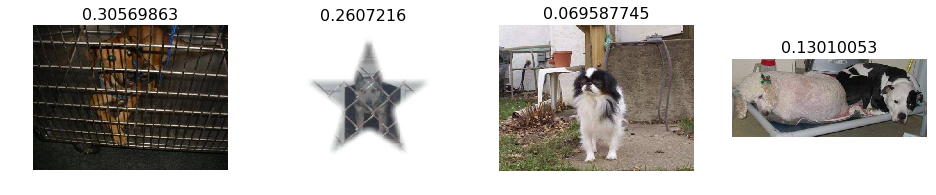

In [23]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

Most correct cats


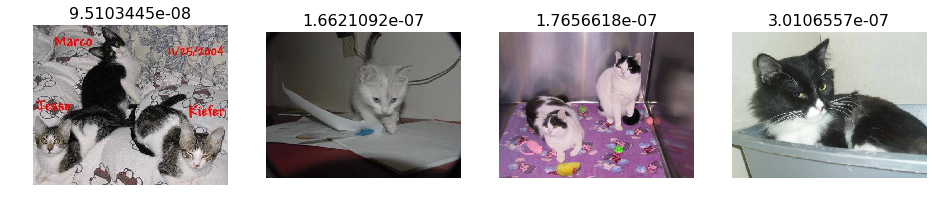

In [24]:
# 3. The most correct labels of each class (i.e. those with highest probability that are correct)
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


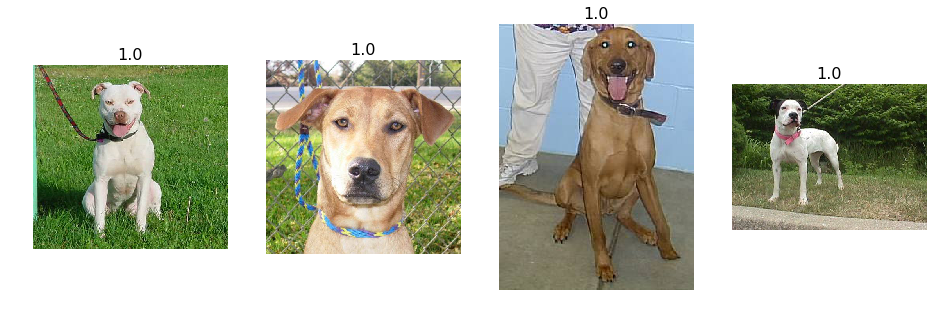

In [25]:
# 4. The most correct labels of each class (i.e. those with highest probability that are correct)
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


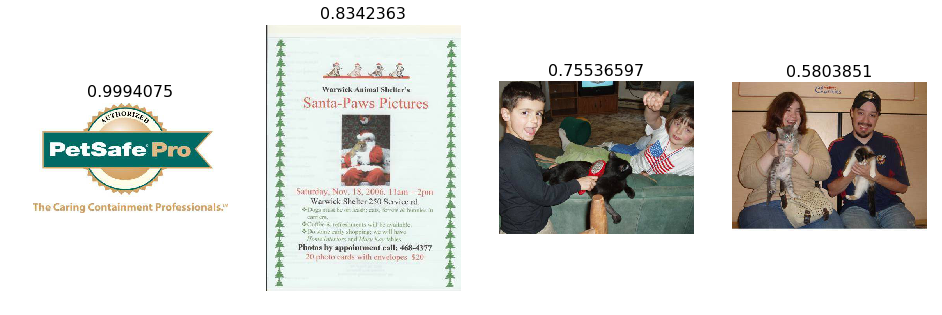

In [26]:
# 5. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


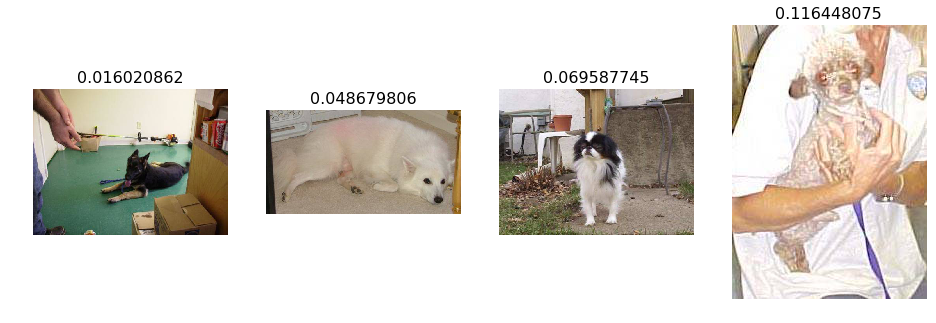

In [27]:
# 6. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most Uncetain Predictions


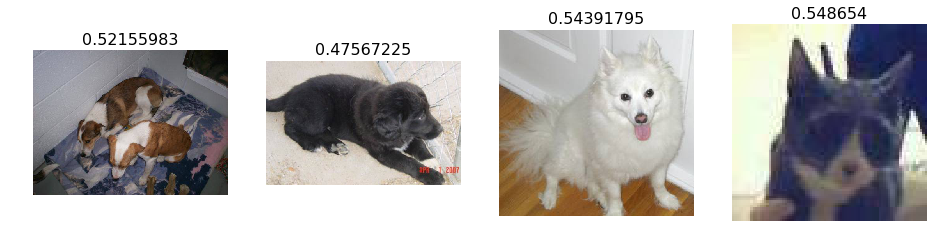

In [28]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, 'Most Uncetain Predictions')

- Why is it important to look at these images?Is to find a way to visualize what it has built. Because if we wants to make the model better, then we needs to take advantage of the things that is doing well and fix the things that is doing badly.

- In this case, we have learned something about the dataset itself which is that there are some images that are in here that probably should not be. But it is also clear that this model has room to improve (e.g. data augmentation — which we will learn later)

### Choosing a learning rate

The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.


The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

 78%|███████▊  | 279/360 [00:05<00:01, 47.97it/s, loss=0.39]  


Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

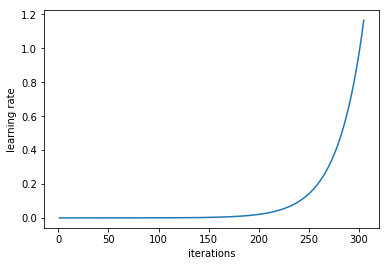

In [30]:
learn.sched.plot_lr()

Note that in the previous plot iteration is one iteration (or minibatch) of SGD. In one epoch there are (num_train_samples/batch_size) iterations of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

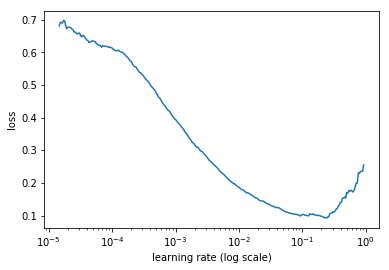

In [31]:
learn.sched.plot()

- We then pick the learning rate where the loss is still clearly improving — in this case 1e-2 (0.01)

#### Choosing number of epochs 

-  As many as you would like, but accuracy might start getting worse if you run it for too long. It is something called “overfitting”
- Another consideration is the available time.

## Review of last lesson 

- We used 3 lines of code to build an image classifier.
- In order to train the model, data needs to be organized in a certain way under PATH (in this case data/dogscats/)
- There should be train folder and valid folder, and under each of these, folders with classification labels (i.e. cats and dogs for this example) with corresponding images in them.
- The training output: `[epoch #, training loss, validation loss, accuracy]`

**Learning Rate**
- The basic idea of learning rate is that it is going to decide how quickly we zoom/hone in on the solution.
- If the learning rate is too small, it will take very long time to get to the bottom
- If the learning rate is too big, it could get oscillate away from the bottom.
- Learning rate finder (learn.lr_find) will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. We then look at the plot of learning rate against loss, and determine the lowest point and go back by one magnitude and choose that as a learning rate (1e-2 in the example below).
- Mini-batch is a set of few images we look at each time so that we are using the parallel processing power of the GPU effectively (generally 64 or 128 images at a time)
- Learning rate finder sits on top of other optimizers (e.g. momentum, Adam, etc) and help you choose the best learning rate given what other tweaks you are using (such as advanced optimizers but not limited to optimizers).

## Improving our model

**Data Augmentation**

If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.

- Every epoch, we will randomly change the image a little bit. In other words, the model is going to see slightly different version of the image each epoch

- You want to use different types of data augmentation for different types of image (flip horizontally, vertically, zoom in, zoom out, vary contrast and brightness, and many more).

In [41]:
arch = resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.047407   0.02926    0.989     



[array([0.02926]), 0.989]

- transform_side_on — a predefined set of transformations for side-on photos (there is also transform_top_down). Later we will learn how to create custom transform lists.
- It is not exactly creating new data, but allows the convolutional neural net to learn how to recognize cats or dogs from somewhat different angles.

In [42]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

### Visualize augmented data

In [49]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [50]:
ims = np.stack([get_augs() for i in range(6)])

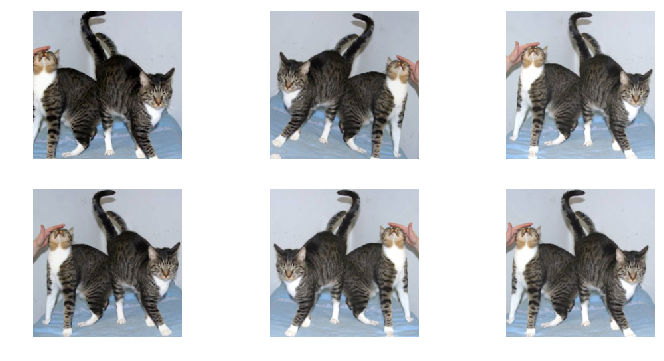

In [51]:
plots(ims, rows=2)

In [52]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.053879   0.026188   0.9915    



[array([0.02619]), 0.9915]

- Now we created a new data object that includes augmentation. Initially, the augmentations actually do nothing because of `precompute=True`.

- Convolutional neural network have these things called `“activations.”` An activation is a number that says “this feature is in this place with this level of confidence (probability)”. We are using a pre-trained network which has already learned to recognize features (i.e. we do not want to change hyper parameters it learned), so what we can do is to pre-compute activations for hidden layers and just train the final linear portion.

- This is why when you train your model for the first time, it takes longer — it is pre-computing these activations.

- Even though we are trying to show a different version of the cat each time, we had already pre-computed the activations for a particular version of the cat (i.e. we are not re-calculating the activations with the altered version).

- To use data augmentation, we have to do `learn.precompute=False`

In [53]:
learn.precompute = False

By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.

In [54]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.042955   0.025169   0.9905    
    1      0.041032   0.026031   0.99                         
    2      0.038352   0.02899    0.989                        



[array([0.02899]), 0.989]

- `cycle_len=1`: This enables **stochastic gradient descent with restarts (SGDR)**. The basic idea is as you get closer and closer to the spot with the minimal loss, you may want to start decrease the learning rate (taking smaller steps) in order to get to exactly the right spot.

- The idea of decreasing the learning rate as you train is called **learning rate annealing** which is very common. Most common and “hacky” way to do this is to train a model with a certain learning rate for a while, and when it stops improving, manually drop down the learning rate (stepwise annealing).

- A better approach is simply to pick some kind of functional form — turns out the really good functional form is one half of the cosign curve which maintains the high learning rate for a while at the beginning, then drop quickly when you get closer.

- We may find ourselves in a part of the weight space that isn’t very resilient — that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the ‘restarts’ in ‘SGDR’), which will force the model to jump to a different part of the weight space if the current area is “spiky”. 

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is referred to as the `number of cycles`, and is what we're actually passing as the 2nd parameter to `fit()`

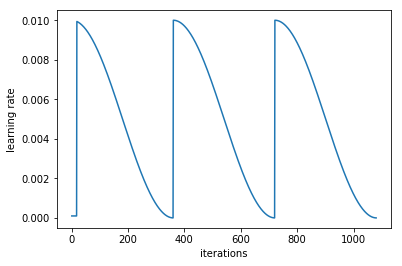

In [55]:
learn.sched.plot_lr()

It is important to pick a learning rate (which is the highest learning rate SGDR uses) that is big enough to allow the reset to jump to a different part of the function

SGDR reduces the learning rate every mini-batch, and reset occurs every cycle_len epoch (in this case it is set to 1)

If you want to skip ahead, there is a parameter called cycle_save_name which you can add as well as cycle_len, which will save a set of weights at the end of every learning rate cycle and then you can ensemble them 

## Saving model

In [56]:
learn.save('224_lastlayer')

In [57]:
learn.load('224_lastlayer')

- When you precompute activations or create resized images (we will learn about it soon), various temporary files get created which you see under data/dogcats/tmp folder. If you are getting weird errors, it might be because of precomputed activations that are only half completed or are in some way incompatible with what you are doing. So you can always go ahead and delete this /tmp folder to see if it makes the error go away (fast.ai equivalent of turning it off and then on again).

- You will also see there is a directory called /models that is where models get saved when you say learn.save

## Fine-tuning and differential learning rate annealing

- So far, we have not retrained any of pre-trained features — specifically, any of those weights in the convolutional kernels. All we have done is we added some new layers on top and learned how to mix and match pre-trained features.

- Images like satellite images, CT scans, etc have totally different kinds of features all together (compare to ImageNet images), so you want to re-train many layers.

- For dogs and cats, images are similar to what the model was pre-trained with, but we still may find it is helpful to slightly tune some of the later layers.

- Here is how you tell the learner that we want to start actually changing the convolutional filters themselves

In [58]:
learn.unfreeze()

- frozen layer is a layer which is not being trained/updated. unfreeze unfreezes all the layers.
- the earlier layers have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.
- Later layers are much more likely to need more learning. So we create an array of learning rates

In [59]:
lr = np.array([1e-4, 1e-3, 1e-2])

- `1e-4` : for the first few layers (basic geometric features)
- `1e-3` : for the middle layers (sophisticated convolutional features)
- `1e-2` : for layers we added on top

Why 3? Actually they are 3 ResNet blocks but for now, think of it as a group of layers.

In [60]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049787   0.028111   0.99      
    1      0.047528   0.02358    0.9905                       
    2      0.0313     0.02152    0.9925                       
    3      0.033336   0.021771   0.991                        
    4      0.024121   0.018374   0.992                        
    5      0.023392   0.019823   0.9915                       
    6      0.015791   0.019206   0.991                        



[array([0.01921]), 0.991]

- `cycle_len=2`: it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of 
- `cycle_mult=2`: this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

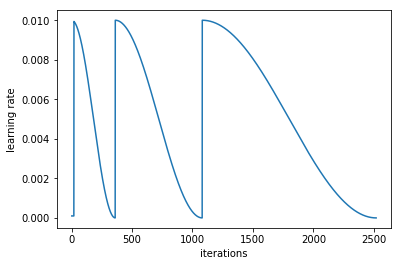

In [61]:
learn.sched.plot_lr()

if the cycle length is too short, it starts going down to find a good spot, then pops out, and goes down trying to find a good spot and pops out, and never actually get to find a good spot. Earlier on, you want it to do that because it is trying to find a spot that is smoother, but later on, you want it to do more exploring. That is why cycle_mult=2 seems to be a good approach.

In [62]:
learn.save('224_all')

In [63]:
learn.load('224_all')

## Test Time Augmentation (TTA)

- There is something else we can do with data augmentation: use it at inference time (also known as test time). Not surprisingly, this is known as test time augmentation, or just TTA.

- TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.

In [64]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [65]:
accuracy_np(probs, y)

0.994

## Analyzing results

#### Confusion Matrix

In [67]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  7 993]]


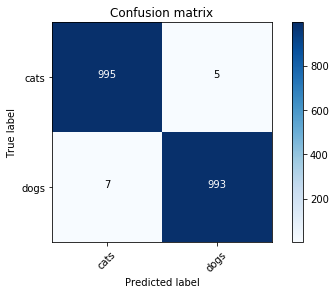

In [69]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


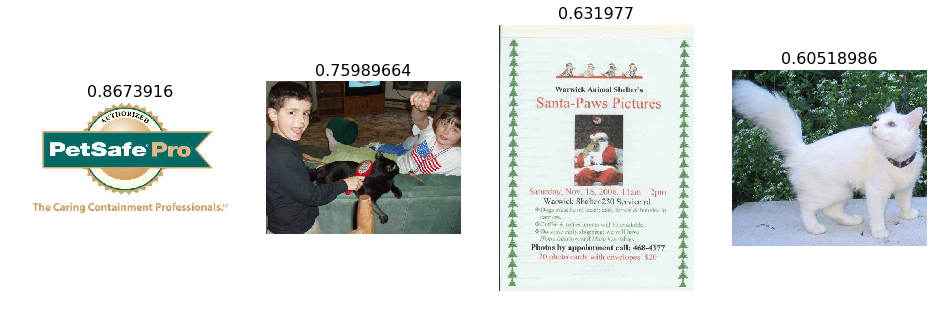

In [70]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


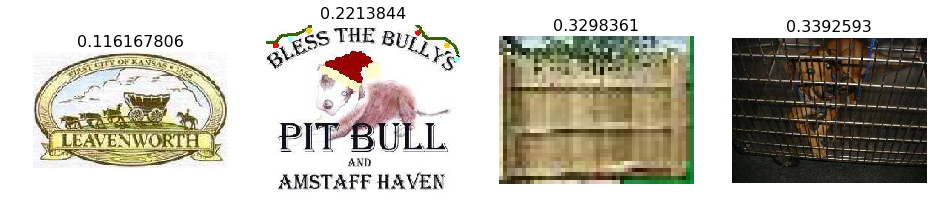

In [71]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

### Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and `Precompute=True`
2. Use `lr_find()` to find the highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for `1-2 epochs`
4. Train last layer with data augmentation (i.e. `precompute=False`) for 2-3 epochs with `cycle_len=1`
5. `Unfreeze` all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use `lr_find()` again
8. Train full network with `cycle_mult=2` until over-fitting